In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import torchvision.utils as vutils
from torchvision import models, transforms

import matplotlib.pyplot as plt
import numpy as np
import os
import random
from facenet_pytorch import InceptionResnetV1, MTCNN

In [4]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando {device} para entrenar')

Usando cpu para entrenar


## Cargar datos

In [5]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

DATASET = os.path.abspath('real_and_fake_face/')
INITIAL_SIZE_OF_IMAGES = (160, 160)

In [6]:
data_transforms = transforms.Compose([
    transforms.Resize(INITIAL_SIZE_OF_IMAGES),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizar cada canal
])

dataset = datasets.ImageFolder(root=DATASET, transform=data_transforms)

In [15]:
train_size = int(0.8 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

# Transformaciones a los conjuntos de datos (train, valid, test)
train_dataset.transform = data_transforms
valid_dataset.transform = data_transforms
test_dataset.transform = data_transforms

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False)

In [11]:
print('Porcentaje de cada clase en train:')

total_0 = 0
total_1 = 0
for images, labels in train_loader:
    total_0 += (labels == 0).sum().item()
    total_1 += (labels == 1).sum().item()

total_samples = len(train_loader.dataset)
porcentaje_0 = (total_0 / total_samples) * 100
porcentaje_1 = (total_1 / total_samples) * 100

print(f'Porcentaje de 0: {porcentaje_0}%')
print(f'Porcentaje de 1: {porcentaje_1}%')

Porcentaje de cada clase en train:
Porcentaje de 0: 47.24264705882353%
Porcentaje de 1: 52.75735294117647%


## Modelos

### Modelo 1.

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)


        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64*16*16, 128)

        self.fc2 = nn.Linear(128, 64)
        
        self.fc3 = nn.Linear(64, 2)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x),negative_slope = 0.01))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 64*16*16)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [8]:
model = CNN().to(device)
print(model)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.01)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [9]:
num_epochs = 10
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    training_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        training_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = training_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)
    valid_accuracy = 100 * correct_valid / total_valid
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}%')

    model.train()

print("Entrenamiento finalizado!")

KeyboardInterrupt: 

### Modelo 2.

In [10]:
class CNNBatch(nn.Module):
    def __init__(self):
        super(CNNBatch, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(32*32*32, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        x = x.view(-1, 32*32*32)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

In [11]:
model = CNNBatch().to(device)
print(model)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

CNNBatch(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [12]:
num_epochs = 10
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    training_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        training_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = training_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)
    valid_accuracy = 100 * correct_valid / total_valid
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}%')

    model.train()

print("Entrenamiento finalizado!")

Epoch [1/10], Train Loss: 2.3520, Train Acc: 50.74%, Valid Loss: 0.6891, Valid Acc: 54.90%
Epoch [2/10], Train Loss: 0.7906, Train Acc: 50.06%, Valid Loss: 0.6870, Valid Acc: 54.90%
Epoch [3/10], Train Loss: 0.7116, Train Acc: 50.31%, Valid Loss: 0.6942, Valid Acc: 45.59%
Epoch [4/10], Train Loss: 0.7058, Train Acc: 50.74%, Valid Loss: 0.6925, Valid Acc: 51.96%
Epoch [5/10], Train Loss: 0.6969, Train Acc: 50.80%, Valid Loss: 0.6928, Valid Acc: 52.45%
Epoch [6/10], Train Loss: 0.6951, Train Acc: 52.88%, Valid Loss: 0.6900, Valid Acc: 50.98%
Epoch [7/10], Train Loss: 0.6952, Train Acc: 52.08%, Valid Loss: 0.6857, Valid Acc: 54.90%
Epoch [8/10], Train Loss: 0.6947, Train Acc: 53.62%, Valid Loss: 0.6922, Valid Acc: 45.59%
Epoch [9/10], Train Loss: 0.6897, Train Acc: 54.23%, Valid Loss: 0.6857, Valid Acc: 55.39%
Epoch [10/10], Train Loss: 0.6900, Train Acc: 53.80%, Valid Loss: 0.6813, Valid Acc: 50.98%
Entrenamiento finalizado!


### Modelo 3. LeNet-5

In [13]:
class CNNLeNet(nn.Module):
    def __init__(self):
        super(CNNLeNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5, padding=1)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5,padding=1) 
        
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5,padding=1)
        self.pool = nn.AvgPool2d(2, 2)

        self.fc1 = nn.Linear(120*28*28, 84)
        self.fc2 = nn.Linear(84, 2)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.tanh(self.conv1(x)))
        x = self.pool(F.tanh(self.conv2(x)))
        x = F.tanh(self.conv3(x))

        x = x.view(-1, 120*28*28)

        x = self.dropout(F.tanh(self.fc1(x)))
        x = self.fc2(x)
        return x

In [14]:
model = CNNLeNet().to(device)
print(model)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

CNNLeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=94080, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [15]:
num_epochs = 10
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    training_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        training_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = training_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)
    valid_accuracy = 100 * correct_valid / total_valid
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}%')

    model.train()

print("Entrenamiento finalizado!")

Epoch [1/10], Train Loss: 0.8383, Train Acc: 51.47%, Valid Loss: 0.6942, Valid Acc: 54.41%
Epoch [2/10], Train Loss: 0.7611, Train Acc: 49.94%, Valid Loss: 0.6904, Valid Acc: 53.92%
Epoch [3/10], Train Loss: 0.7489, Train Acc: 50.25%, Valid Loss: 0.6919, Valid Acc: 54.41%
Epoch [4/10], Train Loss: 0.7361, Train Acc: 50.86%, Valid Loss: 0.6875, Valid Acc: 54.90%
Epoch [5/10], Train Loss: 0.7362, Train Acc: 50.00%, Valid Loss: 0.6904, Valid Acc: 54.41%
Epoch [6/10], Train Loss: 0.7320, Train Acc: 47.37%, Valid Loss: 0.6894, Valid Acc: 53.92%
Epoch [7/10], Train Loss: 0.7070, Train Acc: 52.08%, Valid Loss: 0.6896, Valid Acc: 54.41%
Epoch [8/10], Train Loss: 0.7061, Train Acc: 51.65%, Valid Loss: 0.6877, Valid Acc: 54.41%
Epoch [9/10], Train Loss: 0.7112, Train Acc: 49.26%, Valid Loss: 0.6882, Valid Acc: 54.41%
Epoch [10/10], Train Loss: 0.7129, Train Acc: 49.26%, Valid Loss: 0.6916, Valid Acc: 53.92%
Entrenamiento finalizado!


### Modelo 4

In [16]:
class CNNLeNetBatch(nn.Module):
    def __init__(self):
        super(CNNLeNetBatch, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5, padding=1)
        self.bn1 = nn.BatchNorm2d(6) 
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5,padding=1) 
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5,padding=1)
        self.bn3 = nn.BatchNorm2d(120)

        self.pool = nn.AvgPool2d(2, 2)

        self.fc1 = nn.Linear(120*28*28, 84)  # Capa F6
        self.fc2 = nn.Linear(84, 64)
        self.fc3 = nn.Linear(64, 2)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))

        x = x.view(-1, 120*28*28)

        x = self.dropout(F.tanh(self.fc1(x)))
        x = self.dropout(F.tanh(self.fc2(x)))
        x = self.fc3(x)
        return x

In [17]:
model = CNNLeNetBatch().to(device)
print(model)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

CNNLeNetBatch(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=94080, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [18]:
num_epochs = 10
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    training_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        training_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = training_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)
    valid_accuracy = 100 * correct_valid / total_valid
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}%')

    model.train()

print("Entrenamiento finalizado!")

Epoch [1/10], Train Loss: 0.7634, Train Acc: 48.84%, Valid Loss: 0.6867, Valid Acc: 54.90%
Epoch [2/10], Train Loss: 0.7154, Train Acc: 50.37%, Valid Loss: 0.6864, Valid Acc: 54.90%
Epoch [3/10], Train Loss: 0.7173, Train Acc: 49.39%, Valid Loss: 0.6923, Valid Acc: 54.90%
Epoch [4/10], Train Loss: 0.7048, Train Acc: 49.82%, Valid Loss: 0.6879, Valid Acc: 54.90%
Epoch [5/10], Train Loss: 0.7064, Train Acc: 51.23%, Valid Loss: 0.6895, Valid Acc: 54.90%
Epoch [6/10], Train Loss: 0.7105, Train Acc: 50.43%, Valid Loss: 0.6911, Valid Acc: 54.90%
Epoch [7/10], Train Loss: 0.7028, Train Acc: 50.74%, Valid Loss: 0.6896, Valid Acc: 54.90%
Epoch [8/10], Train Loss: 0.7016, Train Acc: 50.18%, Valid Loss: 0.6910, Valid Acc: 54.90%
Epoch [9/10], Train Loss: 0.7007, Train Acc: 49.88%, Valid Loss: 0.6871, Valid Acc: 54.90%
Epoch [10/10], Train Loss: 0.6959, Train Acc: 50.80%, Valid Loss: 0.6874, Valid Acc: 54.90%
Entrenamiento finalizado!


### Modelo 5

In [19]:
class CNNLeNetBatch(nn.Module):
    def __init__(self):
        super(CNNLeNetBatch, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,padding=1) 
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3,padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.pool = nn.AvgPool2d(2, 2)

        self.fc1 = nn.Linear(64*16*16, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 2)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = x.view(-1, 64*16*16)

        x = self.dropout(F.tanh(self.fc1(x)))
        x = self.dropout(F.tanh(self.fc2(x)))
        x = self.dropout(F.tanh(self.fc3(x)))
        x = self.fc4(x)
        return x

In [20]:
model = CNNLeNetBatch().to(device)
print(model)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

CNNLeNetBatch(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [21]:
num_epochs = 10
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    training_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        training_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = training_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)
    valid_accuracy = 100 * correct_valid / total_valid
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}%')

    model.train()

print("Entrenamiento finalizado!")

Epoch [1/10], Train Loss: 0.7016, Train Acc: 52.94%, Valid Loss: 0.6902, Valid Acc: 52.45%
Epoch [2/10], Train Loss: 0.7133, Train Acc: 49.69%, Valid Loss: 0.6895, Valid Acc: 54.90%
Epoch [3/10], Train Loss: 0.6994, Train Acc: 52.88%, Valid Loss: 0.6949, Valid Acc: 46.57%
Epoch [4/10], Train Loss: 0.7016, Train Acc: 50.25%, Valid Loss: 0.6862, Valid Acc: 54.90%
Epoch [5/10], Train Loss: 0.7020, Train Acc: 50.98%, Valid Loss: 0.6960, Valid Acc: 45.59%
Epoch [6/10], Train Loss: 0.7007, Train Acc: 51.41%, Valid Loss: 0.6866, Valid Acc: 54.90%
Epoch [7/10], Train Loss: 0.6985, Train Acc: 52.45%, Valid Loss: 0.6901, Valid Acc: 54.90%
Epoch [8/10], Train Loss: 0.6937, Train Acc: 51.35%, Valid Loss: 0.6859, Valid Acc: 54.90%
Epoch [9/10], Train Loss: 0.6966, Train Acc: 51.23%, Valid Loss: 0.6895, Valid Acc: 54.90%
Epoch [10/10], Train Loss: 0.6959, Train Acc: 50.55%, Valid Loss: 0.6907, Valid Acc: 49.51%
Entrenamiento finalizado!


### Modelo 2 avg
optimizer = optim.Adadelta(model.parameters(), lr=0.1, rho=0.95, eps=1e-8, weight_decay=0.001)

In [22]:
class CNNBatch(nn.Module):
    def __init__(self):
        super(CNNBatch, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)

        self.pool = nn.AvgPool2d(2, 2)

        self.fc1 = nn.Linear(32*32*32, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        x = x.view(-1, 32*32*32)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

In [23]:
model = CNNBatch().to(device)
print(model)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=0.01)

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=0.1)
])

train_loader.transform = transform
valid_loader.transform = transform

CNNBatch(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [24]:
num_epochs = 10
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    training_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        training_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = training_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)
    valid_accuracy = 100 * correct_valid / total_valid
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}%')

    model.train()

print("Entrenamiento finalizado!")

Epoch [1/10], Train Loss: 0.6940, Train Acc: 53.98%, Valid Loss: 0.6864, Valid Acc: 54.90%
Epoch [2/10], Train Loss: 0.6812, Train Acc: 55.51%, Valid Loss: 0.6750, Valid Acc: 54.90%
Epoch [3/10], Train Loss: 0.6632, Train Acc: 59.50%, Valid Loss: 0.6775, Valid Acc: 54.90%
Epoch [4/10], Train Loss: 0.6623, Train Acc: 59.99%, Valid Loss: 0.6665, Valid Acc: 59.31%
Epoch [5/10], Train Loss: 0.6553, Train Acc: 61.09%, Valid Loss: 0.6596, Valid Acc: 59.31%
Epoch [6/10], Train Loss: 0.6384, Train Acc: 63.91%, Valid Loss: 0.7033, Valid Acc: 57.35%
Epoch [7/10], Train Loss: 0.6380, Train Acc: 64.58%, Valid Loss: 0.6530, Valid Acc: 59.31%
Epoch [8/10], Train Loss: 0.6194, Train Acc: 66.85%, Valid Loss: 0.6667, Valid Acc: 54.41%
Epoch [9/10], Train Loss: 0.6144, Train Acc: 66.79%, Valid Loss: 0.6404, Valid Acc: 56.86%
Epoch [10/10], Train Loss: 0.6038, Train Acc: 66.61%, Valid Loss: 0.6559, Valid Acc: 60.29%
Entrenamiento finalizado!


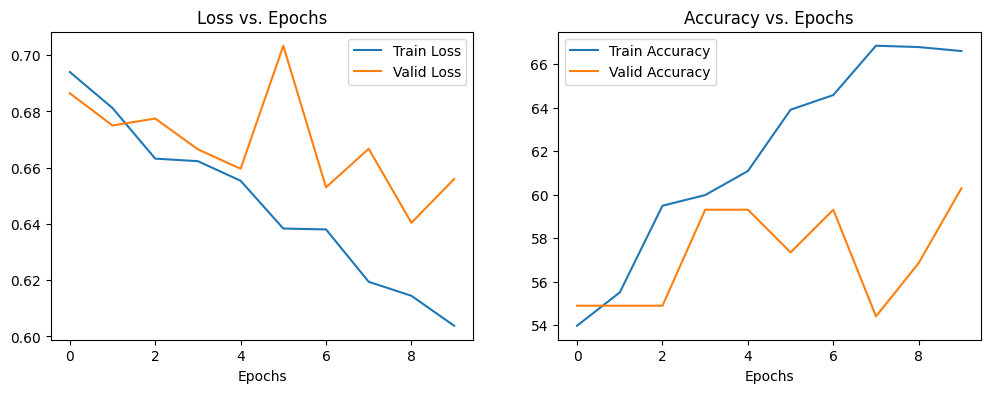

In [25]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.legend()
plt.xlabel('Epochs')
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.title('Accuracy vs. Epochs')

plt.show()

In [26]:
model.eval()
with torch.no_grad(): # Deshabilita el cálculo de gradientes
    correct = 0
    total = 0
    for images, labels in test_loader:
        # pasar al dispositivo
        images = images.to(device)
        labels = labels.to(device)
        ############################
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) # Obtiene el índice de la clase con mayor probabilidad
        total += labels.size(0) # Tamaño del batch
        correct += (predicted == labels).sum().item() # Suma el número de predicciones correctas

    print(f'Precisión del modelo en las 10000 imágenes de prueba: {100 * correct / total}%')

Precisión del modelo en las 10000 imágenes de prueba: 65.36585365853658%


## Probarndo el transferLearning

In [10]:
from torchvision import models, transforms

In [39]:
alexnet = models.alexnet(pretrained=True)

In [40]:
for param in alexnet.features.parameters():
    param.requires_grad = False

In [41]:
num_classes = 2
alexnet.classifier = nn.Sequential(
    nn.Linear(256 * 6 * 6, 1024), 
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),  # Menos neuronas en esta capa
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)


In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=0.001)
num_epochs = 10
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    training_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = alexnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = training_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    alexnet.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = alexnet(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)
    valid_accuracy = 100 * correct_valid / total_valid
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}%')

    alexnet.train()

print("Entrenamiento finalizado!")


Epoch [1/10], Train Loss: 1.0224, Train Acc: 50.12%, Valid Loss: 0.6835, Valid Acc: 54.90%
Epoch [2/10], Train Loss: 0.7167, Train Acc: 53.74%, Valid Loss: 0.6850, Valid Acc: 55.39%
Epoch [3/10], Train Loss: 0.6919, Train Acc: 53.74%, Valid Loss: 0.6708, Valid Acc: 55.39%
Epoch [4/10], Train Loss: 0.6785, Train Acc: 56.13%, Valid Loss: 0.6615, Valid Acc: 57.84%
Epoch [5/10], Train Loss: 0.6486, Train Acc: 62.62%, Valid Loss: 0.6675, Valid Acc: 57.84%
Epoch [6/10], Train Loss: 0.6407, Train Acc: 62.07%, Valid Loss: 0.6384, Valid Acc: 54.90%
Epoch [7/10], Train Loss: 0.6226, Train Acc: 63.97%, Valid Loss: 0.6382, Valid Acc: 56.86%
Epoch [8/10], Train Loss: 0.6073, Train Acc: 67.28%, Valid Loss: 0.6855, Valid Acc: 62.25%
Epoch [9/10], Train Loss: 0.5618, Train Acc: 69.98%, Valid Loss: 0.6519, Valid Acc: 54.90%
Epoch [10/10], Train Loss: 0.5517, Train Acc: 71.75%, Valid Loss: 0.6852, Valid Acc: 61.27%
Entrenamiento finalizado!


## ResNet 18

In [14]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando {device} para entrenar')

Usando cuda para entrenar


In [15]:
train_size = int(0.8 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])


massive_data_augmentation = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización
])

train_dataset.dataset.transform = massive_data_augmentation
valid_dataset.dataset.transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_dataset.dataset.transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Crear DataLoader para cada conjunto de datos (train, valid, test)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, shuffle=False)

In [16]:
resnet18 = models.resnet18(pretrained=True)

c:\Users\marap\miniconda3\envs\aa2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\marap\miniconda3\envs\aa2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
for param in resnet18.parameters():
    param.requires_grad = False

In [19]:
#resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, 2)
resnet18.fc = nn.Sequential(
    nn.Linear(resnet18.fc.in_features, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(256, 2),
)


AttributeError: 'Sequential' object has no attribute 'in_features'

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
resnet18 = models.resnet18().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adadelta(resnet18.parameters(), lr=1)
num_epochs = 10
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    resnet18.train()
    training_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = resnet18(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = training_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    resnet18.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)
    valid_accuracy = 100 * correct_valid / total_valid
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}%')

print("Entrenamiento finalizado!")

Epoch [1/10], Train Loss: 1.6099, Train Acc: 48.53%, Valid Loss: 1.4629, Valid Acc: 52.45%
Epoch [2/10], Train Loss: 0.9037, Train Acc: 50.37%, Valid Loss: 0.8107, Valid Acc: 47.06%
Epoch [3/10], Train Loss: 0.8279, Train Acc: 51.29%, Valid Loss: 0.7817, Valid Acc: 53.92%
Epoch [4/10], Train Loss: 0.8120, Train Acc: 51.96%, Valid Loss: 0.7698, Valid Acc: 53.92%
Epoch [5/10], Train Loss: 0.7573, Train Acc: 55.76%, Valid Loss: 0.8116, Valid Acc: 52.45%
Epoch [6/10], Train Loss: 0.7512, Train Acc: 55.64%, Valid Loss: 1.0849, Valid Acc: 47.55%
Epoch [7/10], Train Loss: 0.7735, Train Acc: 57.29%, Valid Loss: 0.7873, Valid Acc: 52.94%
Epoch [8/10], Train Loss: 0.7232, Train Acc: 57.66%, Valid Loss: 0.7361, Valid Acc: 54.41%
Epoch [9/10], Train Loss: 0.7524, Train Acc: 57.48%, Valid Loss: 0.7945, Valid Acc: 55.88%
Epoch [10/10], Train Loss: 0.6582, Train Acc: 64.15%, Valid Loss: 0.7373, Valid Acc: 58.33%
Entrenamiento finalizado!


### ResNet 34

In [78]:
model = models.resnet34(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(128, 2)
)
for param in model.fc.parameters():
    param.requires_grad = True

print(model)

c:\Users\Susana\anaconda3\envs\aa2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Susana\anaconda3\envs\aa2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [94]:
#OJo modelo
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.fc.parameters(), lr=0.1)
num_epochs = 10
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    model.train()
    training_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = training_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)
    valid_accuracy = 100 * correct_valid / total_valid
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}%')

print("Entrenamiento finalizado!")

Epoch [1/10], Train Loss: 0.6962, Train Acc: 52.63%, Valid Loss: 0.7040, Valid Acc: 50.00%
Epoch [2/10], Train Loss: 0.6947, Train Acc: 53.43%, Valid Loss: 0.6891, Valid Acc: 55.88%
Epoch [3/10], Train Loss: 0.6849, Train Acc: 54.72%, Valid Loss: 0.6842, Valid Acc: 50.98%
Epoch [4/10], Train Loss: 0.6826, Train Acc: 57.41%, Valid Loss: 0.6774, Valid Acc: 58.82%
Epoch [5/10], Train Loss: 0.6736, Train Acc: 57.97%, Valid Loss: 0.6868, Valid Acc: 62.75%
Epoch [6/10], Train Loss: 0.6707, Train Acc: 58.52%, Valid Loss: 0.6705, Valid Acc: 56.37%
Epoch [7/10], Train Loss: 0.6651, Train Acc: 59.01%, Valid Loss: 0.6713, Valid Acc: 58.82%
Epoch [8/10], Train Loss: 0.6540, Train Acc: 60.60%, Valid Loss: 0.6759, Valid Acc: 59.80%
Epoch [9/10], Train Loss: 0.6554, Train Acc: 60.91%, Valid Loss: 0.6496, Valid Acc: 56.37%
Epoch [10/10], Train Loss: 0.6381, Train Acc: 63.36%, Valid Loss: 0.7243, Valid Acc: 55.88%
Entrenamiento finalizado!


## FaceNet

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = InceptionResnetV1(pretrained='vggface2', classify=True).to(device)

In [51]:
for param in model.parameters():
    param.requires_grad = False

num_features = model.last_linear.in_features

#Cambiar esta parte
custom_fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(256, 2), 
)

model.last_linear = custom_fc

model = model.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)


In [54]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
num_epochs = 10
train_losses = []   
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    model.train()
    torch.set_grad_enabled(True)
    training_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = training_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            model.eval()
            torch.set_grad_enabled(False)

            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)
    valid_accuracy = 100 * correct_valid / total_valid
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}%')

print("Entrenamiento finalizado!")

RuntimeError: running_mean should contain 2 elements not 512

# MTCNN

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MTCNN(keep_all=True, device=device)

In [ ]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

### VGGFace


In [125]:
from facenet_pytorch import MTCNN, InceptionResnetV1, training
from torch.optim.lr_scheduler import MultiStepLR

In [126]:
train_size = int(0.8 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])


massive_data_augmentation = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización
])

train_dataset.dataset.transform = massive_data_augmentation
valid_dataset.dataset.transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_dataset.dataset.transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, shuffle=False)

In [127]:
model = InceptionResnetV1(pretrained='vggface2').to(device)

In [128]:
weights = model.state_dict()
i = 0

for name, param in reversed(weights.items()):
    print(f"Layer: {name}")
    #print(f"Param: {param}")
    if i == 12:
        break
    i+=1

Layer: logits.bias
Layer: logits.weight
Layer: last_bn.num_batches_tracked
Layer: last_bn.running_var
Layer: last_bn.running_mean
Layer: last_bn.bias
Layer: last_bn.weight
Layer: last_linear.weight
Layer: block8.conv2d.bias
Layer: block8.conv2d.weight
Layer: block8.branch1.2.bn.num_batches_tracked
Layer: block8.branch1.2.bn.running_var
Layer: block8.branch1.2.bn.running_mean


In [129]:
model.last_linear = nn.Linear(1792, 512).to(device)
model.last_linear = nn.Sequential(
    model.last_linear,
    nn.Dropout(p=0.5)
).to(device)
model.last_bn = nn.BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True).to(device)
model.logits = nn.Linear(512, 256).to(device)
model.logits2 = nn.Linear(256, 128).to(device)
model.classify = nn.Linear(128, 2).to(device)

In [130]:
for name, param in model.named_parameters():
    if name not in ["logits.bias", "logits.weight", "last_bn.bias", "last_bn.weight", "last_linear.weight", "classify.weight", "classify.bias", 
                    "logits2.weight", "logits2.bias"]:
        param.requires_grad = False

Modificar el modelo.

In [131]:
for name,param in model.named_parameters():
    if param.requires_grad:
        print(name)

last_bn.weight
last_bn.bias
logits.weight
logits.bias
logits2.weight
logits2.bias
classify.weight
classify.bias


In [132]:
for name, param in model.named_parameters():
    print(f"Name: {name}, param: {param.requires_grad}")

Name: conv2d_1a.conv.weight, param: False
Name: conv2d_1a.bn.weight, param: False
Name: conv2d_1a.bn.bias, param: False
Name: conv2d_2a.conv.weight, param: False
Name: conv2d_2a.bn.weight, param: False
Name: conv2d_2a.bn.bias, param: False
Name: conv2d_2b.conv.weight, param: False
Name: conv2d_2b.bn.weight, param: False
Name: conv2d_2b.bn.bias, param: False
Name: conv2d_3b.conv.weight, param: False
Name: conv2d_3b.bn.weight, param: False
Name: conv2d_3b.bn.bias, param: False
Name: conv2d_4a.conv.weight, param: False
Name: conv2d_4a.bn.weight, param: False
Name: conv2d_4a.bn.bias, param: False
Name: conv2d_4b.conv.weight, param: False
Name: conv2d_4b.bn.weight, param: False
Name: conv2d_4b.bn.bias, param: False
Name: repeat_1.0.branch0.conv.weight, param: False
Name: repeat_1.0.branch0.bn.weight, param: False
Name: repeat_1.0.branch0.bn.bias, param: False
Name: repeat_1.0.branch1.0.conv.weight, param: False
Name: repeat_1.0.branch1.0.bn.weight, param: False
Name: repeat_1.0.branch1.0.bn

In [135]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

In [136]:
num_epochs = 20
train_losses = []   
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    model.train()
    torch.set_grad_enabled(True)

    training_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = training_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            torch.set_grad_enabled(False)

            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)
    valid_accuracy = 100 * correct_valid / total_valid
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}%')

print("Entrenamiento finalizado!")

Epoch [1/20], Train Loss: 0.7278, Train Acc: 58.03%, Valid Loss: 0.6715, Valid Acc: 58.82%
Epoch [2/20], Train Loss: 0.7333, Train Acc: 56.56%, Valid Loss: 0.7304, Valid Acc: 57.84%
Epoch [3/20], Train Loss: 0.7111, Train Acc: 58.09%, Valid Loss: 0.7042, Valid Acc: 57.35%
Epoch [4/20], Train Loss: 0.7435, Train Acc: 56.43%, Valid Loss: 0.6560, Valid Acc: 57.35%
Epoch [5/20], Train Loss: 0.7294, Train Acc: 57.84%, Valid Loss: 0.6794, Valid Acc: 57.35%
Epoch [6/20], Train Loss: 0.7186, Train Acc: 58.33%, Valid Loss: 0.6993, Valid Acc: 57.84%
Epoch [7/20], Train Loss: 0.7207, Train Acc: 58.33%, Valid Loss: 0.6885, Valid Acc: 57.35%
Epoch [8/20], Train Loss: 0.7013, Train Acc: 59.07%, Valid Loss: 0.6658, Valid Acc: 56.86%
Epoch [9/20], Train Loss: 0.7256, Train Acc: 57.23%, Valid Loss: 0.6827, Valid Acc: 56.86%
Epoch [10/20], Train Loss: 0.7048, Train Acc: 57.66%, Valid Loss: 0.6941, Valid Acc: 57.84%
Epoch [11/20], Train Loss: 0.7061, Train Acc: 59.44%, Valid Loss: 0.6655, Valid Acc: 57.3

KeyboardInterrupt: 

Regularizacion

earlystoppin

validacion cruzada

reduccion de complejidad


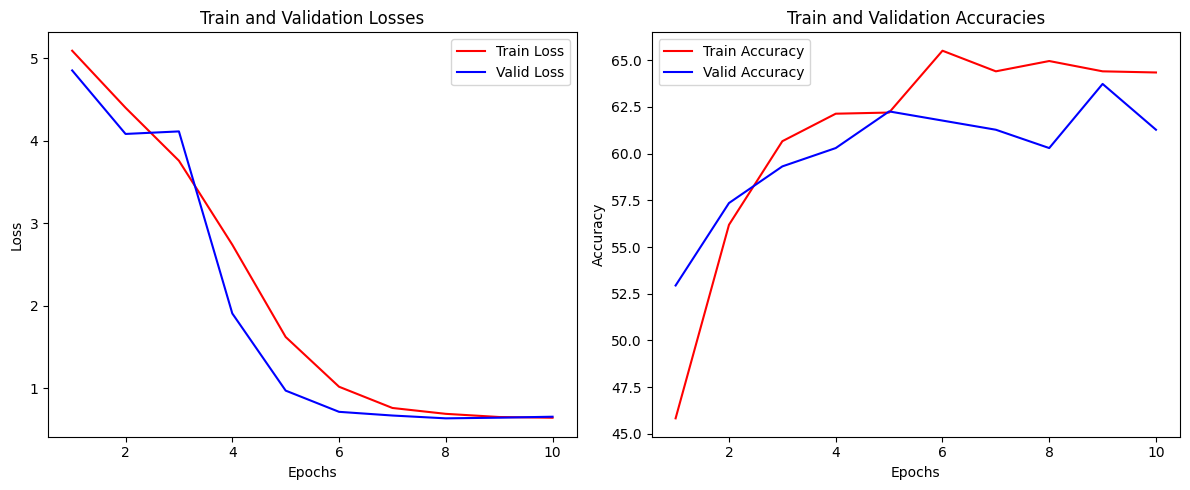

In [99]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r', label='Train Loss')
plt.plot(epochs, valid_losses, 'b', label='Valid Loss')
plt.title('Train and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'r', label='Train Accuracy')
plt.plot(epochs, valid_accuracies, 'b', label='Valid Accuracy')
plt.title('Train and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluando el modelo

In [100]:
from sklearn.metrics import confusion_matrix

model.eval()
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)


[[55 42]
 [43 65]]


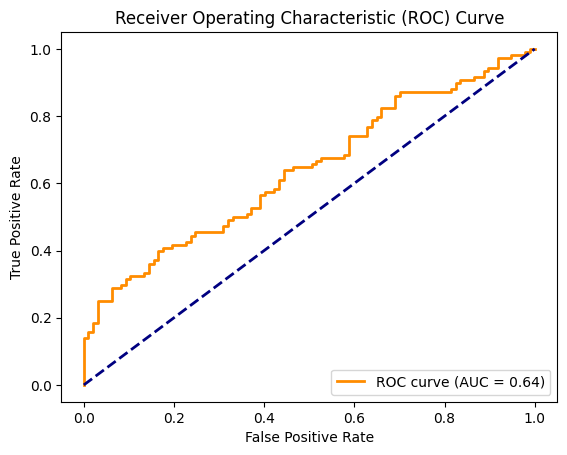

In [102]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    all_labels = []
    all_predictions = []
    for images, labels in test_loader:
        outputs = model(images)
        predicted_probs = torch.softmax(outputs, dim=1)
        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted_probs.numpy())

all_predictions = np.array(all_predictions) 
fpr, tpr, thresholds = roc_curve(all_labels, all_predictions[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
